In [1]:
import math
import warnings
from typing import TYPE_CHECKING, Optional
import io

import random
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import error, spaces
from gymnasium.error import DependencyNotInstalled
from gymnasium.utils import EzPickle, colorize
from gymnasium.utils.step_api_compatibility import step_api_compatibility

import pygame

import Box2D
from Box2D.b2 import (
    circleShape,
    contactListener,
    edgeShape,
    fixtureDef,
    polygonShape,
    revoluteJointDef,
    staticBody, 
    dynamicBody
)

import pygame

import torch
from torch import nn
from collections import deque
import pickle

### **state Space**
$(x, y, p_x, p_y, angle, L, mass, intertia)$ : most simplified

### **observation**
(FOV array)

### **Action space**
(Propulsion (acc in facing angle), angular velocity)
```python
thrust, angular_momentum = action
thrust = np.clip(thrust, 0., 1.)
angular_momentum = np.clip(angular_momentum, -1., 1.) * UAV_ANG_POW
thrust_force = thrust_direction * thrust * UAV_THRUST_POW
```
Note the input of thrust and angular momentum needs to be interpretated as 0-100%, -100%-100%

### **Rewards**
*   increase/decrease the closer/durther the agent is to the goal.
*   increase/decrease the larger/smaller the magnitute of velocity $||v||$.
*   increase/decrease the larger/smaller the $\%$ of obstacle in FOV.

The episode receive an additional reward of -100 for crashing.

An episode is considered a solution if it reaches score.

### **Starting State**
The agent starts at the left ceter of the viewpoirt, with a initial $v_x$

### **Episode Termination**
If:
* The agent crashes
* The agent gets outside of the viewport

In [2]:
try:
    env.close()
except:
    pass

# Constants
FPS = 50
SCALE = 10.0  # Scaling for visualization
OBSTACLE_SCALE = 5.0  # Scaling for obstacles
UAV_RADIUS = 10.0 / SCALE  # Radius of the UAV
GOAL_RADIUS = UAV_RADIUS  # Radius of the Goal
VIEWPORT_W = 600
VIEWPORT_H = 400
WALL_THICKNESS = 10. / SCALE # Thickness of the walls
NUM_OBSTACLES = 10  # Number of obstacles
OBS_MAX_RAD = min(VIEWPORT_W, VIEWPORT_H) / SCALE / OBSTACLE_SCALE # Maximum radius of obstacles
OBS_MIN_RAD = OBS_MAX_RAD / 3  # Minimum radius of obstacles
MIN_CLEARANCE = UAV_RADIUS * 3  # Minimum clearance between obstacles

#Note: For the angle in box2d, 0 rad is at 3 o'clock, and positive angle is in the clockwise direction

# UAV specs
UAV_INI_ANGLE = np.deg2rad(0)
UAV_DENSITY = 1.0
UAV_FRICTION = 0.3
UAV_FOV = np.deg2rad(360)  # Field of View in degrees
UAV_NUM_RAYS = 20  # Number of rays in the FOV array
UAV_FOV_DISTANCE = 200 / SCALE  # Maximum sensing distance
UAV_ANG_POW = 100 /SCALE  # Maximum angular velocity (deg/s?)
UAV_THRUST_POW = 100 / SCALE  # Maximum thrust (Unit/s?)

# Action/State
ACTION_SPACE = 4
STATE_SPACE = 7 + UAV_NUM_RAYS

# Penalty/Reward coeff
PEN_THRUST = -0.1/FPS
PEN_ANG = -0.05/FPS
PEN_OBSTACLE = -1
PEN_COLLISION = -100
PEN_NOT_FINISHED = -100
REW_VEL = 1/FPS
REW_ANGLE = 1/FPS
REW_GOAL = 100
REW_DIST2GOAL = 5

class ContactDetector(Box2D.b2ContactListener):
    def __init__(self, env):
        super(ContactDetector, self).__init__()
        self.env = env

    def BeginContact(self, contact):
        # Check if one of the bodies is the UAV and the other is an obstacle or wall
        if contact.fixtureA.body == self.env.uav or contact.fixtureB.body == self.env.uav:
            self.env.game_over = True

class SimpleUAVEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': FPS}

    def __init__(self):
        # Define the Box2D world
        self.world = Box2D.b2World(gravity=(0, 0))
        self.uav = None  # UAV object
        self.goal = None  # Goal position
        self.dist2goal = None  # Distance to goal
        self.walls = []  # Walls
        self.obstacles = []  # Store properties of obstacles
        self.obstacles_properties = []
        self.uav_pos_history = []

        self.continuous = False

        if self.continuous:
            raise NotImplementedError
        else:
            self.action_space = spaces.Discrete(ACTION_SPACE)

        # For rendering
        self.screen = None
        self.isopen = True

    def _create_walls(self):
        # Create walls around the viewport
        wall_shapes = [
            edgeShape(vertices=[(0, 0), (VIEWPORT_W/SCALE, 0)]),  # Bottom
            edgeShape(vertices=[(0, 0), (0, VIEWPORT_H/SCALE)]),  # Left
            edgeShape(vertices=[(0, VIEWPORT_H/SCALE), (VIEWPORT_W/SCALE, VIEWPORT_H/SCALE)]),  # Top
            edgeShape(vertices=[(VIEWPORT_W/SCALE, 0), (VIEWPORT_W/SCALE, VIEWPORT_H/SCALE)])  # Right
        ]
        for shape in wall_shapes:
            wall_body = self.world.CreateStaticBody(
                position=(0, 0),
                shapes=shape
            )
            self.walls.append(wall_body)

    def _is_position_valid(self, new_properties):
        # Check against existing obstacles
        for prop in self.obstacles_properties:
            distance = math.sqrt((new_properties['centroid_x'] - prop['centroid_x'])**2 + 
                                (new_properties['centroid_y'] - prop['centroid_y'])**2)
            if distance < (new_properties['max_span'] + prop['max_span'] + MIN_CLEARANCE):
                return False

        # Check distance to the goal
        goal_distance = math.sqrt((new_properties['centroid_x'] - self.goal[0])**2 +
                                (new_properties['centroid_y'] - self.goal[1])**2)
        if goal_distance < (new_properties['max_span'] + 1.5*UAV_RADIUS):
            return False

        # Check distance to the uav starting position
        uav_distance = math.sqrt((new_properties['centroid_x'] - self.uav_start_pos[0])**2 +
                                (new_properties['centroid_y'] - self.uav_start_pos[1])**2)
        if uav_distance < (new_properties['max_span'] + 1.5*UAV_RADIUS):
            return False

        return True
    
    def _generate_triangle_properties(self):
        # Randomly generate centroid within bounds
        centroid_x = random.uniform(UAV_RADIUS, VIEWPORT_W / SCALE - UAV_RADIUS)
        centroid_y = random.uniform(UAV_RADIUS, VIEWPORT_H / SCALE - UAV_RADIUS)
        
        # Random length from centroid to vertices
        length = random.uniform(OBS_MIN_RAD, OBS_MAX_RAD)

        # Angle offsets for equilateral triangle vertices
        angle_offset = math.pi * 2 / 3

        # Calculate vertices based on centroid and length
        vertices = []
        for i in range(3):
            angle = angle_offset * i
            vertex_x = centroid_x + length * math.cos(angle)
            vertex_y = centroid_y + length * math.sin(angle)
            vertices.append((vertex_x, vertex_y))

        # Random rotation angle
        rotation_angle = random.uniform(0, math.pi)

        return {'type': 'triangle', 'vertices': vertices, 'centroid_x': centroid_x, 'centroid_y': centroid_y, 'angle': rotation_angle, 'max_span': length}

    def _generate_rectangle_properties(self):
        width = random.uniform(OBS_MIN_RAD, OBS_MAX_RAD)
        height = random.uniform(OBS_MIN_RAD, OBS_MAX_RAD)
        angle = random.uniform(0, math.pi)  # Random angle in radians

        centroid_x = random.uniform(width / 2, VIEWPORT_W / SCALE - width / 2)
        centroid_y = random.uniform(height / 2, VIEWPORT_H / SCALE - height / 2)

        return {'type': 'rectangle', 'centroid_x': centroid_x, 'centroid_y': centroid_y, 'width': width, 'height': height, 'angle': angle, 'max_span': max(width, height)}

    def _generate_circle_properties(self):
        radius = random.uniform(OBS_MIN_RAD, OBS_MAX_RAD)
        centroid_x = random.uniform(radius, VIEWPORT_W / SCALE - radius)
        centroid_y = random.uniform(radius, VIEWPORT_H / SCALE - radius)

        return {'type': 'circle', 'centroid_x': centroid_x, 'centroid_y': centroid_y, 'max_span': radius}

    def _create_obstacle_from_properties(self, properties):
        if properties['type'] == 'circle':
            body = self.world.CreateStaticBody(position=(properties['centroid_x'], properties['centroid_y']))
            circle = body.CreateCircleFixture(radius=properties['max_span'], density=1, friction=0.3)
            self.obstacles.append(circle)

        elif properties['type'] == 'rectangle':
            body = self.world.CreateStaticBody(position=(properties['centroid_x'], properties['centroid_y']))
            rectangle = body.CreatePolygonFixture(box=(properties['width'] / 2, properties['height'] / 2), density=1, friction=0.3)
            body.angle = properties['angle']
            self.obstacles.append(rectangle)

        elif properties['type'] == 'triangle':
            vertices = [(v[0] - properties['centroid_x'], v[1] - properties['centroid_y']) for v in properties['vertices']]
            body = self.world.CreateStaticBody(position=(properties['centroid_x'], properties['centroid_y']))
            triangle = body.CreatePolygonFixture(vertices=vertices, density=1, friction=0.3)
            body.angle = properties['angle']
            self.obstacles.append(triangle)

    def _create_obstacles(self, num_obstacles=5):
        num_obstacles = num_obstacles
        obstacle_types = ['triangle', 'rectangle', 'circle']
        max_iter = 1000
        for _ in range(num_obstacles):
            obstacle_type = random.choice(obstacle_types)
            for iter in range(max_iter):
                if obstacle_type == 'triangle':
                    properties = self._generate_triangle_properties()
                elif obstacle_type == 'rectangle':
                    properties = self._generate_rectangle_properties()
                elif obstacle_type == 'circle':
                    properties = self._generate_circle_properties()

                # Check if the new obstacle overlaps with existing ones
                if self._is_position_valid(properties):
                    self.obstacles_properties.append(properties)
                    # Create the actual obstacle based on properties
                    #print(properties['type']+': pass checking')
                    self._create_obstacle_from_properties(properties)
                    break
                #if iter == max_iter - 1:
                #    print('Failed to create: ', obstacle_type)

    def _create_uav(self):
        # Create the UAV at a position away from the left wall
        uav_start_pos = (UAV_RADIUS + 2 * WALL_THICKNESS, VIEWPORT_H / SCALE / 2)
        self.uav_start_pos = uav_start_pos
        self.uav = self.world.CreateDynamicBody(position=uav_start_pos, angle=UAV_INI_ANGLE, linearVelocity=(0,0), angularVelocity=0.0)
        self.uav.CreateCircleFixture(radius=UAV_RADIUS, density=UAV_DENSITY, friction=UAV_FRICTION)

    def _create_goal(self):
        # Create a random goal position away from the right wall
        goal_pos_x = VIEWPORT_W / SCALE - GOAL_RADIUS - 2 * WALL_THICKNESS
        goal_pos_y = random.uniform(WALL_THICKNESS+UAV_RADIUS, VIEWPORT_H / SCALE - UAV_RADIUS)
        self.goal = (goal_pos_x, goal_pos_y)
        self.ini_to_goal_dist = math.sqrt((self.uav_start_pos[0] - self.goal[0])**2 + (self.uav_start_pos[1] - self.goal[1])**2)

    def _calculate_reward(self, obs, action):
        # Distance to goal
        dist2goal = math.sqrt((self.uav.position.x - self.goal[0])**2 + (self.uav.position.y - self.goal[1])**2)
        self.dist2goal = dist2goal
        distance_reward = (1 - dist2goal / self.ini_to_goal_dist) * REW_DIST2GOAL  # Normalize 

        # Velocity reward
        velocity_reward = self.uav.linearVelocity.length * REW_VEL

        # Angle reward
        self.ang2goal = (np.arctan2(self.goal[1] - self.uav.position.y, self.goal[0] - self.uav.position.x) - self.uav.angle + np.pi) % (2 * np.pi) - np.pi
        angle_reward = (1 - abs(self.uav.angle-self.ang2goal)/np.pi) * REW_ANGLE

        # FOV obstacle percentage
        fov_reward = (np.sum(obs / UAV_FOV_DISTANCE) / UAV_NUM_RAYS) * PEN_OBSTACLE

        # Active penalty
        if self.continuous:
            #act_reward = PEN_THRUST * abs(action[0]) + PEN_ANG * abs(action[1])
            raise NotImplementedError
        else:
            #act_reward = PEN_THRUST * (action == 0 or action == 1 or action == 2 or action == 3) + PEN_ANG * (action == 4 or action == 5)
            act_reward = PEN_THRUST if action else 0

        return distance_reward, velocity_reward, angle_reward, fov_reward, act_reward

    def step(self, action):
        assert self.uav is not None, "You forgot to call reset()"

        if self.continuous:
            raise NotImplementedError
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "
        if self.continuous:
            action = action.flatten()
            thrust = action[0]
            left_angular_momentum = action[1]
            right_angular_momentum = action[2]
            angular_momentum = left_angular_momentum - right_angular_momentum
            thrust = np.clip(thrust, 0., 1.)
            angular_momentum = np.clip(angular_momentum, -1., 1.) * UAV_ANG_POW
        else:
            thrust = np.array([0, 0])
            angular_momentum = 0
            if action == 0:
                thrust[0] = 1
            elif action == 1:
                thrust[0] = -1
            elif action == 2:
                thrust[1] = 1
            elif action == 3:
                thrust[1] = -1
            '''
            elif action == 4:
                angular_momentum = UAV_ANG_POW
            elif action == 5:
                angular_momentum = -UAV_ANG_POW
            '''
        self.uav_pos_history.append((self.uav.position.x, self.uav.position.y))
        # Calculate the thrust direction based on the UAV's angle, note the thrust is implemented via impulse (reverse)
        Front_direction = Box2D.b2Vec2(math.cos(self.uav.angle), math.sin(self.uav.angle))
        Right_direction = Box2D.b2Vec2(math.cos(self.uav.angle + math.pi / 2), math.sin(self.uav.angle + math.pi / 2))
        
        thrust_force = (Front_direction * thrust[0] + Right_direction*thrust[1]) * UAV_THRUST_POW

        # Apply the thrust & angular momentum
        self.uav.ApplyLinearImpulse(thrust_force, self.uav.worldCenter, True)
        #self.uav.ApplyTorque((angular_momentum), True)

        # Update the environment state
        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)  # Advance the Box2D world, Step (float timeStep, int32 velocityIterations, int32 positionIterations)
        # Get new observation
        new_obs = self._get_obs()
        # Calculate reward
        distance_reward, velocity_reward, angle_reward, fov_reward, act_reward = self._calculate_reward(new_obs, action)
        reward = distance_reward + velocity_reward + angle_reward + fov_reward + act_reward
        # Check if episode is done
        done = False
        if self.game_over:
            done = True
            reward += PEN_COLLISION
        if self.dist2goal <= 2*GOAL_RADIUS:
            done = True
            reward += REW_GOAL
            print('Goal reached! Vel: ', self.uav.linearVelocity.length)
            frame = self.render()
            plt.imshow(frame)
            plt.show()
            self.close()
        # Additional info (optional)
        raw_reward = np.array((distance_reward/REW_DIST2GOAL,  velocity_reward/REW_VEL, angle_reward/REW_ANGLE, fov_reward/PEN_OBSTACLE, act_reward))
        pos = self.uav.position
        vel = self.uav.linearVelocity

        state = np.array([
            #(pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            #(pos.y - VIEWPORT_H / SCALE / 2) / (VIEWPORT_H / SCALE / 2),
            (self.goal[0]-pos.x) / (VIEWPORT_W / SCALE / 2),
            (self.goal[1]-pos.y) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.uav.angle,
            #20.0 * self.uav.angularVelocity / FPS,
            distance_reward/REW_DIST2GOAL,
            self.ang2goal,
            *(1-new_obs/UAV_FOV_DISTANCE)
        ])

        return state, reward, done, raw_reward

    def _destroy(self):
        if not self.uav:
            return
        self.world.contactListener = None
        self.world.DestroyBody(self.uav)
        self.uav = None
        for obstacle in self.obstacles:
            self.world.DestroyBody(obstacle.body)
        self.obstacles = []  # Store properties of obstacles
        self.obstacles_properties = []
        self.uav_pos_history = []

    def reset(self):
        # Reset the environment to initial state
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref

        self._create_walls()
        self._create_uav()
        self._create_goal()
        self._create_obstacles(NUM_OBSTACLES)
        self.game_over = False

        return self.step(0)[0]

    def _raycast_distance(self, start_pos, angle, max_distance):
        # Calculate the end point of the ray
        end_pos = (start_pos.x + max_distance * math.cos(angle), 
                start_pos.y + max_distance * math.sin(angle))

        # Define a callback class to record ray hits
        class RayCastCallback(Box2D.b2RayCastCallback):
            def __init__(self):
                super(RayCastCallback, self).__init__()
                self.fixture = None
                self.point = None
                self.normal = None

            def ReportFixture(self, fixture, point, normal, fraction):
                self.fixture = fixture
                self.point = Box2D.b2Vec2(point)
                self.normal = Box2D.b2Vec2(normal)
                return fraction  # Returning the fraction leaves the ray cast going to max_distance

        # Create a raycast callback instance
        callback = RayCastCallback()

        # Cast the ray
        self.world.RayCast(callback, start_pos, end_pos)

        # If a hit was recorded, calculate the distance, else return max_distance
        if callback.fixture:
            hit_position = callback.point
            distance = math.sqrt((hit_position.x - start_pos.x)**2 + (hit_position.y - start_pos.y)**2)
            return distance
        else:
            return max_distance

    def _get_obs(self):
        fov_array = np.zeros(UAV_NUM_RAYS)

        start_angle = self.uav.angle - UAV_FOV / 2
        angle_increment = UAV_FOV / UAV_NUM_RAYS

        for i in range(UAV_NUM_RAYS):
            ray_angle = start_angle + i * angle_increment
            distance = self._raycast_distance(self.uav.position, ray_angle, UAV_FOV_DISTANCE)
            fov_array[i] = distance

        return fov_array

    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))

        # Clear screen
        self.screen.fill((255, 255, 255))

        # Draw the UAV
        for body in [self.uav]:  # Currently, we only have the UAV
            for fixture in body.fixtures:
                shape = fixture.shape
                position = body.transform * shape.pos * SCALE
                position = (position[0], VIEWPORT_H - position[1])  # Flip Y
                pygame.draw.circle(self.screen, (255, 0, 0), [int(x) for x in position], int(shape.radius * SCALE))

        # Draw the goal
        goal_position = (self.goal[0] * SCALE, VIEWPORT_H - self.goal[1] * SCALE)
        pygame.draw.circle(self.screen, (0, 255, 0), [int(x) for x in goal_position], int(GOAL_RADIUS * SCALE))

        # Draw the obstacles
        for fixture in self.obstacles:
            shape = fixture.shape
            body = fixture.body

            if isinstance(shape, Box2D.b2CircleShape):
                # For circle shapes
                position = (body.position.x * SCALE, VIEWPORT_H - body.position.y * SCALE)
                pygame.draw.circle(self.screen, (0, 0, 255), [int(x) for x in position], int(shape.radius * SCALE))
            
            elif isinstance(shape, Box2D.b2PolygonShape):
                # For polygon shapes (rectangles, triangles)
                vertices = [(body.transform * v) * SCALE for v in shape.vertices]
                vertices = [(v[0], VIEWPORT_H - v[1]) for v in vertices]
                pygame.draw.polygon(self.screen, (0, 0, 255), vertices)

        wall_color = (0, 0, 0)  # Black color for walls
        for wall in self.walls:
            for fixture in wall.fixtures:
                shape = fixture.shape
                # Since these are edge shapes, they have exactly two vertices
                vertex1, vertex2 = shape.vertices
                vertex1 = (wall.transform * vertex1) * SCALE
                vertex2 = (wall.transform * vertex2) * SCALE
                vertex1 = (vertex1[0], VIEWPORT_H - vertex1[1])  # Flip Y
                vertex2 = (vertex2[0], VIEWPORT_H - vertex2[1])  # Flip Y
                pygame.draw.line(self.screen, wall_color, vertex1, vertex2, int(WALL_THICKNESS * SCALE))

        start_angle = self.uav.angle -UAV_FOV / 2
        angle_increment = UAV_FOV / UAV_NUM_RAYS
        for i in range(UAV_NUM_RAYS):
            ray_angle = start_angle + i * angle_increment
            distance = self._raycast_distance(self.uav.position, ray_angle, UAV_FOV_DISTANCE)
            end_x = self.uav.position.x + distance * math.cos(ray_angle)
            end_y = self.uav.position.y + distance * math.sin(ray_angle)
            pygame.draw.line(self.screen, (0, 255, 0), (self.uav.position.x * SCALE, VIEWPORT_H - self.uav.position.y * SCALE), (end_x * SCALE, VIEWPORT_H - end_y * SCALE))

        if self.uav:
            velocity_vector = self.uav.linearVelocity

            uav_center = (self.uav.position.x * SCALE, VIEWPORT_H - self.uav.position.y * SCALE)
            velocity_end = (uav_center[0] + velocity_vector.x, 
                            uav_center[1] - velocity_vector.y)  # Subtract y because of Pygame's y-axis direction

            pygame.draw.line(self.screen, (0, 0, 0), uav_center, velocity_end, 2) 

        if len(self.uav_pos_history) > 1:
            dash_length = 5
            gap_length = 3
            draw = True
            segment_length = 0

            for i in range(len(self.uav_pos_history) - 1):
                start_pos = self.uav_pos_history[i]
                end_pos = self.uav_pos_history[i + 1]

                # Convert to Pygame coordinates and scale
                start_pos_pygame = (start_pos[0] * SCALE, VIEWPORT_H - start_pos[1] * SCALE)
                end_pos_pygame = (end_pos[0] * SCALE, VIEWPORT_H - end_pos[1] * SCALE)

                # Calculate segment length
                segment_length += ((start_pos_pygame[0] - end_pos_pygame[0]) ** 2 + (start_pos_pygame[1] - end_pos_pygame[1]) ** 2) ** 0.5
                
                if segment_length > dash_length:
                    segment_length = 0
                    draw = not draw

                if draw:
                    pygame.draw.line(self.screen, (255, 0, 0), start_pos_pygame, end_pos_pygame, 2)

        pygame.display.flip()
        return np.transpose(np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2))

    def close(self):
        if self.screen:
            pygame.quit()
            self.screen = None
            self.isopen = False

def capture_pygame_surface(surface):
    # Convert Pygame surface to a 3D numpy array (width, height, RGB)
    image = pygame.surfarray.array3d(surface)
    # Transpose the image array to match the expected format for Matplotlib (height, width, RGB)
    image = np.transpose(image, (1, 0, 2))
    return image

In [3]:
# test reset
env = SimpleUAVEnv()

In [4]:
try:
    env.close()
except:
    pass
env.reset()
env.render()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [5]:
env.close()

In [6]:
import time

# Initialize the environment
observation = env.reset()

# Parameters for the test
total_steps = 1  # Total number of steps in the test
thrust_increment = 1  # Increment in thrust per step
angular_momentum = 0  # Constant angular momentum (for simplicity)

# Run the test
for step in range(total_steps):
    # Gradually increase thrust
    thrust = thrust_increment 

    # Create the action (thrust, angular momentum)
    action = 0

    # Perform a step in the environment
    state, reward, done, raw_reward = env.step(action)

    # Render the current state
    frame = env.render()

    # Break the loop if the episode is done
    if done:
        break

    # Pause for a short time to see the animation
    time.sleep(0.1)

# Close the environment
env.close()
print(raw_reward, reward)

[3.33294310e-03 6.36619759e+00 9.22633074e-01 4.69843744e-01
 0.00000000e+00] -0.3074024153419257


```
state = np.array([
    (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
    (pos.y - VIEWPORT_H / SCALE / 2) / (VIEWPORT_H / SCALE / 2),
    vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
    vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
    self.uav.angle,
    20.0 * self.uav.angularVelocity / FPS,
    distance_reward/REW_DIST2GOAL,
    self.ang2goal,
    *(1-new_obs/UAV_FOV_DISTANCE)
])
```

[ 3.19098568  3.35520079  3.94427498  5.42882961 10.32624714  7.43904305
  6.67054919  6.63459754 20.         20.          6.54426646  5.83200723
 14.49979642 20.         11.01714557 20.         10.32624533  5.42883115
  3.9442761   3.35520138]
[1.79363380e+00 6.67117367e-01 3.81971855e+00 0.00000000e+00
 0.00000000e+00 3.33294310e-03 2.43055366e-01 8.40450716e-01
 8.32239961e-01 8.02786251e-01 7.28558520e-01 4.83687643e-01
 6.28047848e-01 6.66472540e-01 6.68270123e-01 0.00000000e+00
 0.00000000e+00 6.72786677e-01 7.08399639e-01 2.75010179e-01
 0.00000000e+00 4.49142721e-01 0.00000000e+00 4.83687734e-01
 7.28558442e-01 8.02786195e-01 8.32239931e-01]
0.0 55.43850853861483 0.24305536601346134


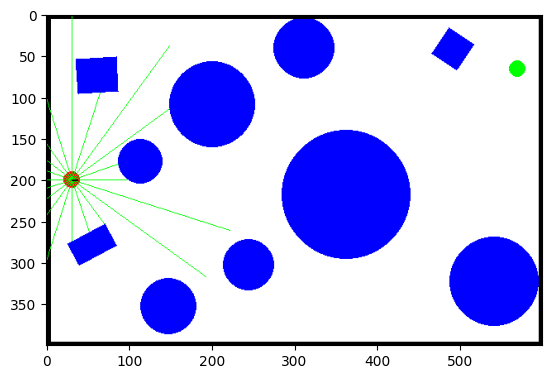

In [7]:
print(env._get_obs())
print(state)
print(env.uav.angle,env.dist2goal, env.ang2goal)
plt.imshow(frame)

In [8]:
print(raw_reward, reward)

[3.33294310e-03 6.36619759e+00 9.22633074e-01 4.69843744e-01
 0.00000000e+00] -0.3074024153419257


In [9]:
class Affine(nn.Module):
    #https://github.com/facebookresearch/deit/blob/263a3fcafc2bf17885a4af62e6030552f346dc71/resmlp_models.py#L16C9-L16C9
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        return self.alpha * x + self.beta    

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, time_emb_dim, dropout=0,
                 skip_scale=1, adaptive_scale=True, affine=False):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = time_emb_dim
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.linear = nn.Linear(in_dim, out_dim)
        self.map_cond = nn.Linear(time_emb_dim, out_dim*(2 if adaptive_scale else 1))

        if affine:
            self.pre_norm = Affine(in_dim)
            self.post_norm = Affine(out_dim)
        else:
            self.pre_norm = nn.Identity()
            self.post_norm = nn.Identity()

    def forward(self, x, time_emb=None):
        #print(x.shape, emb.shape)
        orig = x
        params = nn.functional.silu(self.map_cond(time_emb).to(x.dtype))
        x = self.pre_norm(x)
        if self.adaptive_scale:
            scale, shift = params.chunk(2, dim=-1)
            x = nn.functional.silu(torch.addcmul(shift, x, scale+1))
        else:
            x = nn.functional.silu(x.add_(params))

        x = self.linear(nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = self.post_norm(x)
        x = x.add_(orig)
        x = x * self.skip_scale

        return x

class ResNet(torch.nn.Module):
    def __init__(self, in_dim, out_dim,
                model_dim      = 128,      # dim multiplier.
                dim_mult        = [1,1,1],# dim multiplier for each resblock layer.
                dim_mult_emb    = 4,
                num_blocks          = 2,        # Number of resblocks(mid) per level.
                dropout             = 0.,      # Dropout rate.
                emb_type            = "sinusoidal",# Timestep embedding type
                dim_mult_noise  = 1,        # Time embedding size
                adaptive_scale  = True,     # Feature-wise transformations, FiLM
                skip_scale      = 1.0,      # Skip connection scaling
                affine          = True    # Affine normalization for MLP
                ):

        super().__init__()

        block_kwargs = dict(dropout = dropout, skip_scale=skip_scale, adaptive_scale=adaptive_scale, affine=affine)

        #self.map_layer = nn.Linear(noise_dim, emb_dim)
        #self.map_layer1 = nn.Linear(emb_dim, emb_dim)

        self.state_dim = in_dim-UAV_NUM_RAYS
        self.obs_dim = UAV_NUM_RAYS

        self.first_layer = nn.Linear(self.state_dim, model_dim)
        self.map_obs = nn.Linear(self.obs_dim, model_dim)
        self.blocks = nn.ModuleList()
        cout = model_dim
        self.ini_conv = nn.Conv1d(1, model_dim, kernel_size=4, stride=2, padding=1, padding_mode='circular')
        self.mid_conv = nn.Conv1d(model_dim, model_dim, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.out_conv = nn.ConvTranspose1d(model_dim, 1, kernel_size=4, stride=2, padding=1)
        for level, mult in enumerate(dim_mult):
            for _ in range(num_blocks):
                cin = cout
                cout = model_dim * mult
                self.blocks.append(ResNetBlock(cin, cout, model_dim, **block_kwargs))
        self.final_layer = nn.Linear(cout, out_dim)

    def forward(self, x):
        # Mapping
        #emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape) # why swap emb (sin/cos)?
        #emb = nn.functional.silu(self.map_layer(emb))
        #emb = nn.functional.silu(self.map_layer1(emb))
        #print(x.shape)
        obs = x[:, -UAV_NUM_RAYS:]
        x = x[:, :-UAV_NUM_RAYS]
        
        obs = self.ini_conv(obs.unsqueeze(1))
        obs = self.mid_conv(nn.functional.silu(obs))
        #print(obs.shape)
        obs = self.out_conv(nn.functional.silu(obs)).squeeze(1)
        #print(x.shape, obs.shape)
        x = self.first_layer(x)
        obs = self.map_obs(obs)

        for block in self.blocks:
            x = block(x, obs)
        x = self.final_layer(nn.functional.silu(x))
        return x

In [10]:
class DQN(torch.nn.Module):
    '''
    This class defines a deep Q-network (DQN), a type of artificial neural network used in reinforcement learning.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.
    
    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.
        
        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.nn.functional.silu(self.layer1(state))
        x = torch.nn.functional.silu(self.layer2(x))
        return self.layer3(x)


In [11]:
class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.
    This helps to break the correlation of sequential observations and stabilize the learning process.
    
    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)

In [12]:
class DQNAgent:
    '''
    This class represents a Deep Q-Learning agent that uses a Deep Q-Network (DQN) and a replay memory to interact 
    with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, buffer_size=10000, batch_size=512):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.device = torch.device("cpu")
        
        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        #self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        #self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.q_network = ResNet(state_size, action_size).to(self.device)
        self.target_network = ResNet(state_size, action_size).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
        Perform a step in the environment, store the experience in the replay memory and potentially update the Q-network.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state and the epsilon-greedy policy.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps
        if random.random() > eps:  
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

Episode 100	Average Score: -85.82

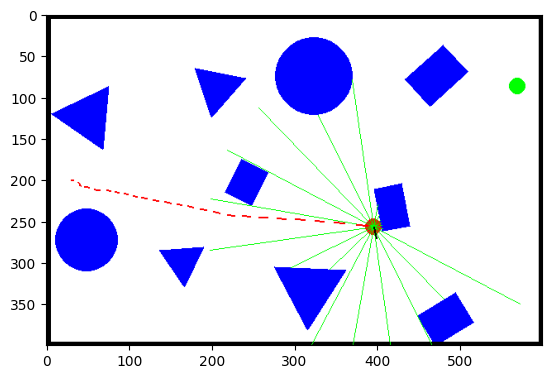

Episode 100	Average Score: -85.82, Eps: 0.606, Terminal vel: 13.860, angle:0.14, dist2goal: 24.28, ang2goal: 0.63, step: 57
Episode 136	Average Score: -74.66Goal reached! Vel:  99.13703155517578


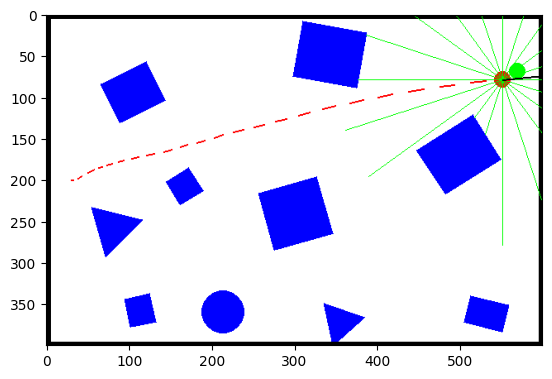

Episode 163	Average Score: -72.72Goal reached! Vel:  100.0


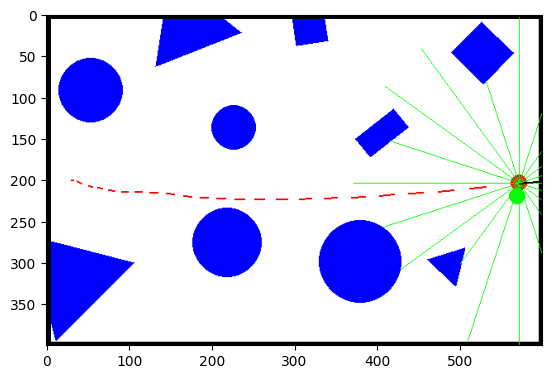

Episode 176	Average Score: -69.99Goal reached! Vel:  100.0000228881836


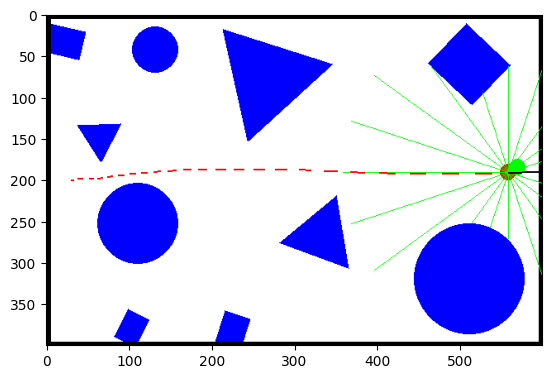

Episode 188	Average Score: -67.57Goal reached! Vel:  99.99999237060547


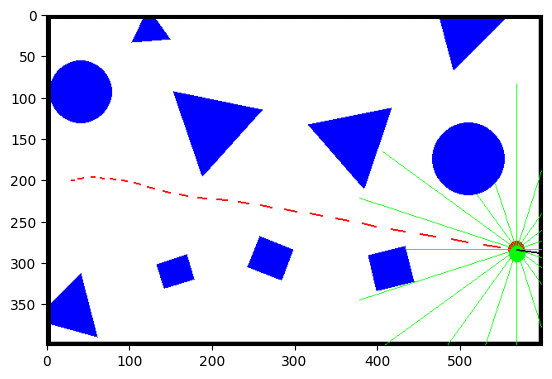

Episode 200	Average Score: -64.77

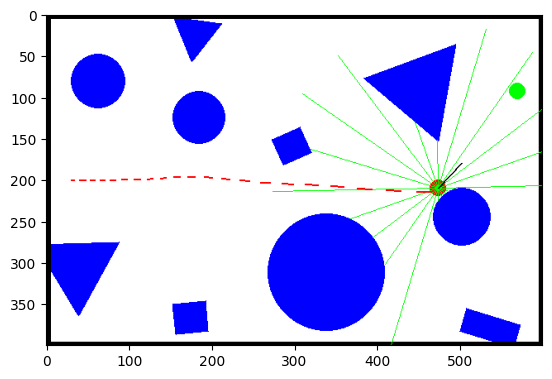

Episode 200	Average Score: -64.77, Eps: 0.367, Terminal vel: 40.236, angle:-0.61, dist2goal: 15.08, ang2goal: 1.49, step: 46
Episode 300	Average Score: -80.96

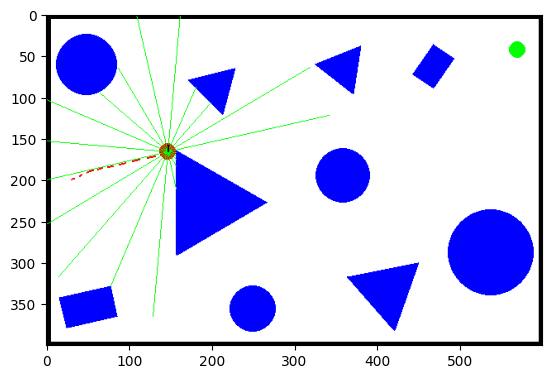

Episode 300	Average Score: -80.96, Eps: 0.222, Terminal vel: 8.342, angle:-0.09, dist2goal: 44.01, ang2goal: 0.37, step: 23
Episode 394	Average Score: -77.74

KeyboardInterrupt: 

In [13]:
def train(agent, env, n_episodes=2000, n_max_step=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10, print_every=10):
    '''
    Train a DQN agent.
    
    Parameters
    ----------
    agent: DQNAgent
        The agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        The number of episodes for which to train the agent.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        The decay rate for epsilon after each episode.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.
        
    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    final_states_images = []

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):
        
        # Reset environment and score at the start of each episode
        state = env.reset()
        score = 0 

        # Loop over steps
        for n_step in range(n_max_step):
            
            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            #print(action)
            next_state, reward, terminated, raw_reward = env.step(action) 
            done = terminated
            
            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            #if n_step % 10 == 0:
            #    print(f"Step {n_step}\tScore: {score:.2f}, step reward: {reward}")
            score += reward

            # End the episode if done
            if done:
                break 
        if n_step == n_max_step - 1:
            score += PEN_NOT_FINISHED

        #print(f"Episode {i_episode}\tScore: {score:.2f}, done: {done}, final reward: {reward}") 
        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score) 

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()
            
        # Print average score every 100 episodes
        if i_episode % print_every == 0:
            frame = env.render()
            final_states_images.append(frame)
            env.close()
            plt.imshow(frame)
            plt.show()
            print('\rEpisode {}\tAverage Score: {:.2f}, Eps: {:.3f}, Terminal vel: {:.3f}, angle:{:.2f}, dist2goal: {:.2f}, ang2goal: {:.2f}, step: {}'
                  .format(i_episode, np.mean(scores_window), eps, np.linalg.norm(env.uav.linearVelocity), env.uav.angle, env.dist2goal, env.ang2goal, n_step))
        
        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break
            

    return scores, final_states_images


# Make an environment
env = SimpleUAVEnv()
state_size = STATE_SPACE
action_size = ACTION_SPACE

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size, learning_rate=0.1)

# Train it
scores, final_states_images = train(agent, env, 2000, print_every=100)

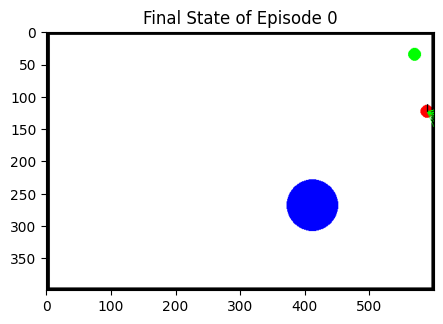

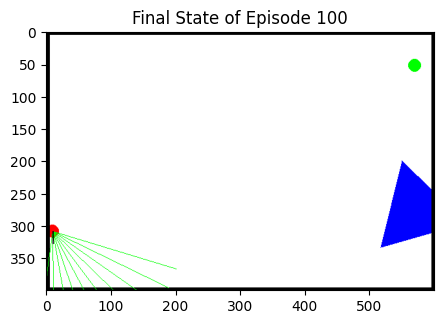

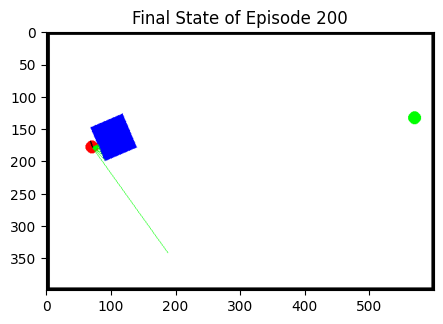

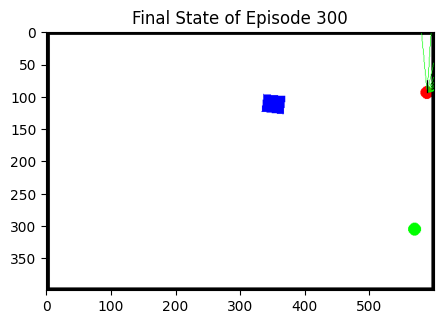

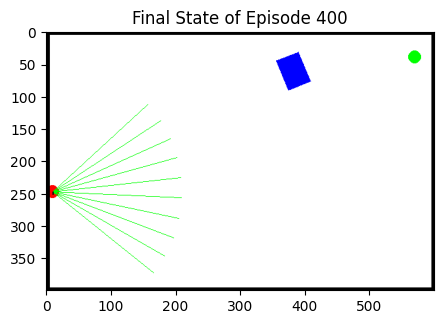

In [ ]:
# Plotting the final states
for i, img in enumerate(final_states_images):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f'Final State of Episode {i*100}')
    plt.show()